### About this Dataset


## PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [16]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import os

os.chdir(r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\data\raw")

In [4]:
PJME_data = pd.read_csv("PJME_hourly.csv")
PJME_data = PJME_data.set_index("Datetime")
PJME_data.index = pd.to_datetime(PJME_data.index)
print("✅ Data loaded successfully")

✅ Data loaded successfully


In [5]:
PJME_data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [6]:
PJME_data.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<function matplotlib.pyplot.show(close=None, block=None)>

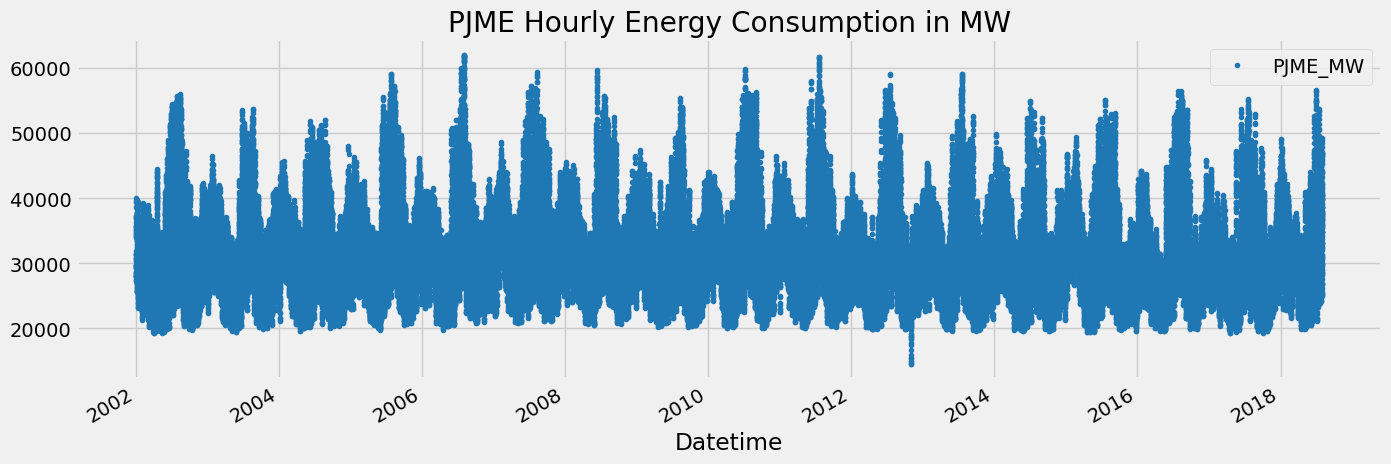

In [7]:
PJME_data.plot(style=".", 
               figsize=(15, 5),
               color=color_pal[0],               
               title="PJME Hourly Energy Consumption in MW",)
plt.show

## Train / Test Spilt

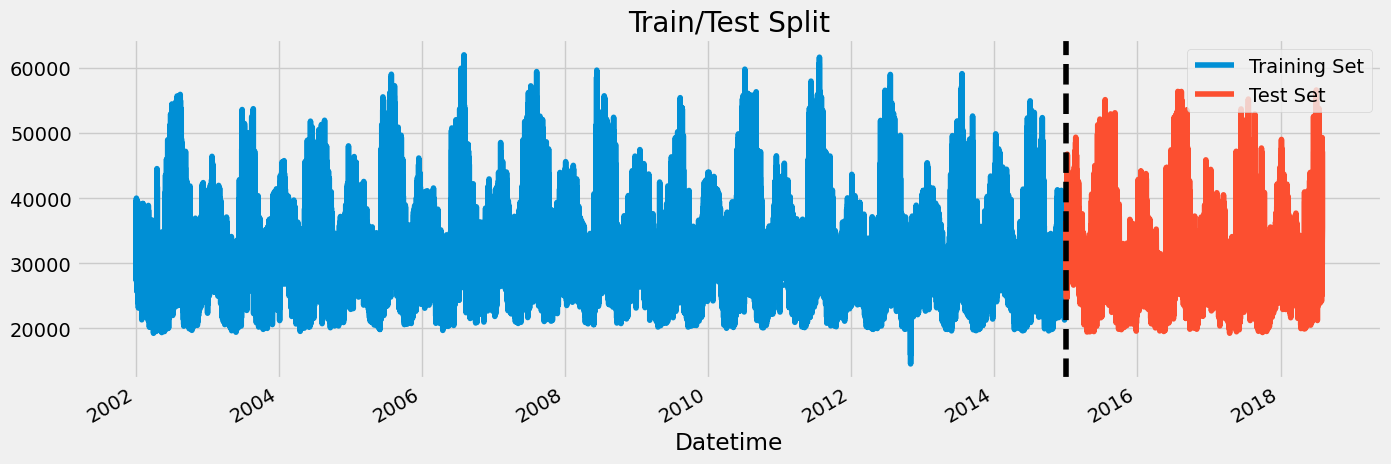

In [8]:
train = PJME_data.loc[PJME_data.index < "01-01-2015"]
test = PJME_data.loc[PJME_data.index >= "01-01-2015"]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label = "Training Set", title="Train/Test Split")
test.plot(ax=ax, label = "Test Set")
ax.axvline("01-01-2015", color="black", linestyle="--")
ax.legend(["Training Set", "Test Set"])
plt.show()

#### Plot of Single week of Data

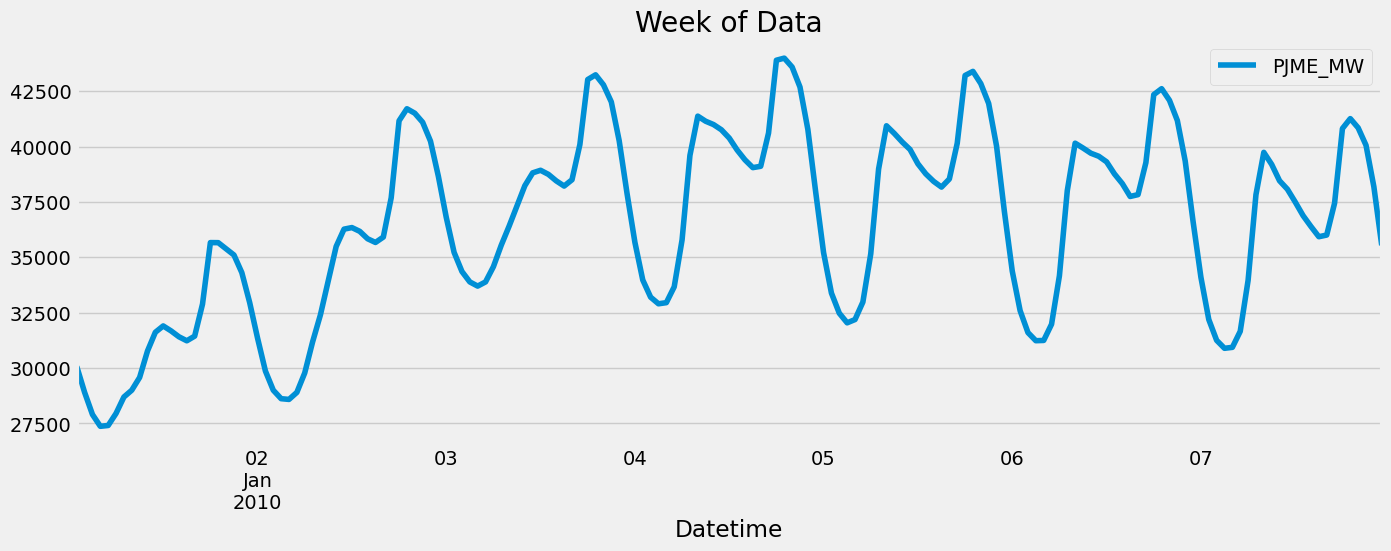

In [ ]:
# Ensure PJME_data is sorted by its index
PJME_data_sorted = PJME_data.sort_index()

#Plot from the sorted DataFrame
PJME_data_sorted.loc[(PJME_data_sorted.index > "01-01-2010") & (PJME_data_sorted.index < "01-08-2010")] \
    .plot(figsize=(15, 5), title="Week of Data")
plt.show()

## Feature Creation

In [24]:

def create_features(df):
    """
    Create time-based features from the index of the DataFrame.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    return df


In [14]:
PJME_data = create_features(PJME_data)

## Visualise the Feature / Target Relationship

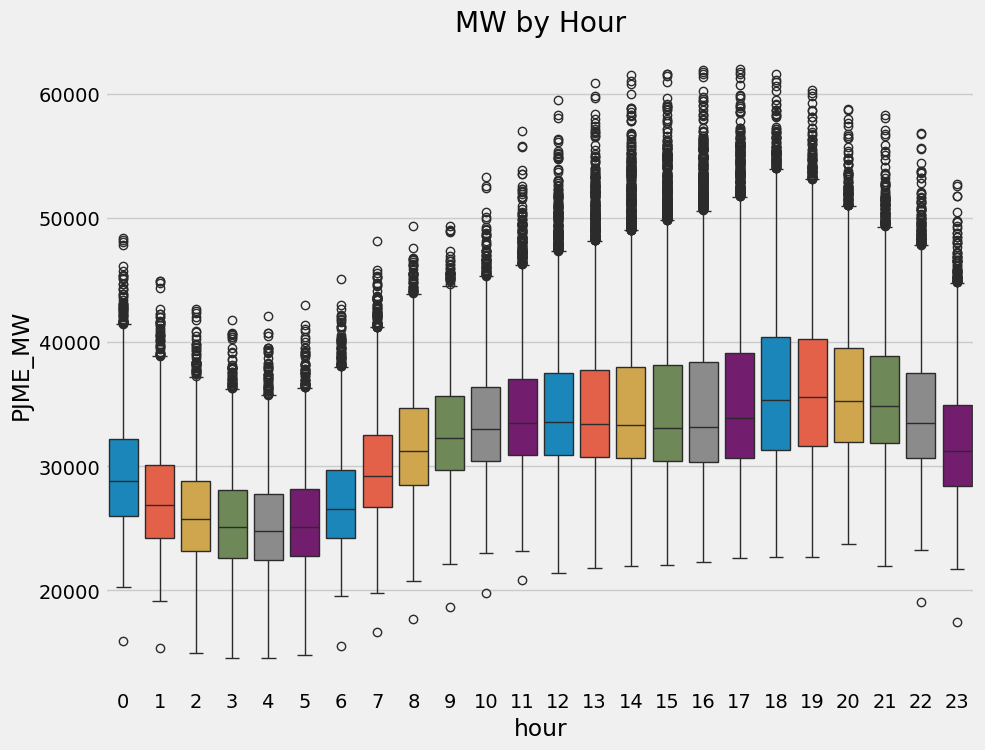

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=PJME_data, x="hour", y="PJME_MW", palette=color_pal)
ax.set_title("MW by Hour")
plt.show()

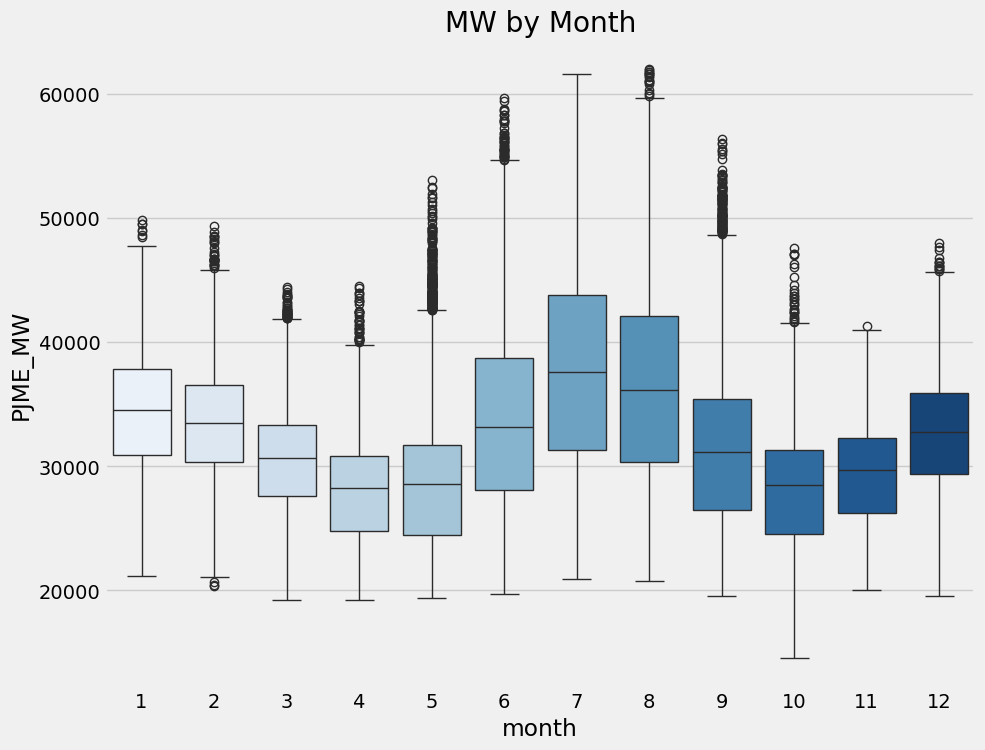

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=PJME_data, x="month", y="PJME_MW", palette="Blues")
ax.set_title("MW by Month")
plt.show()

In [47]:
## Save the processed data
# Set Directory for saving processed data
os.chdir(r"C:\Users\willi\GitHub\TS_Energy_Consumption_XGB\data\processed")
PJME_data.to_csv("PJME_Clean.csv")

In [48]:
# Save the train and test sets
train.to_csv("PJME_Train.csv")
test.to_csv("PJME_Test.csv")
print("✅ Processed data saved successfully")

✅ Processed data saved successfully


# Create Model

In [49]:
train = create_features(train)
test = create_features(test)

FEATURES = ["hour", "dayofweek", "quarter", "month", "dayofyear", "year"]
TARGET = "PJME_MW"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [50]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

## Feature Importance

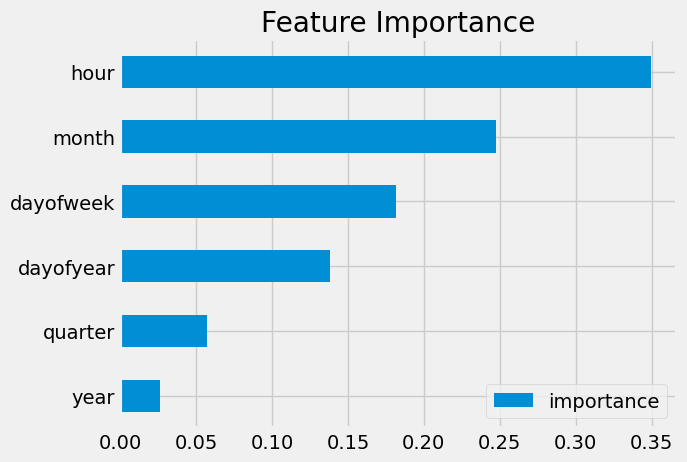

In [51]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns =["importance"])
fi.sort_values("importance").plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

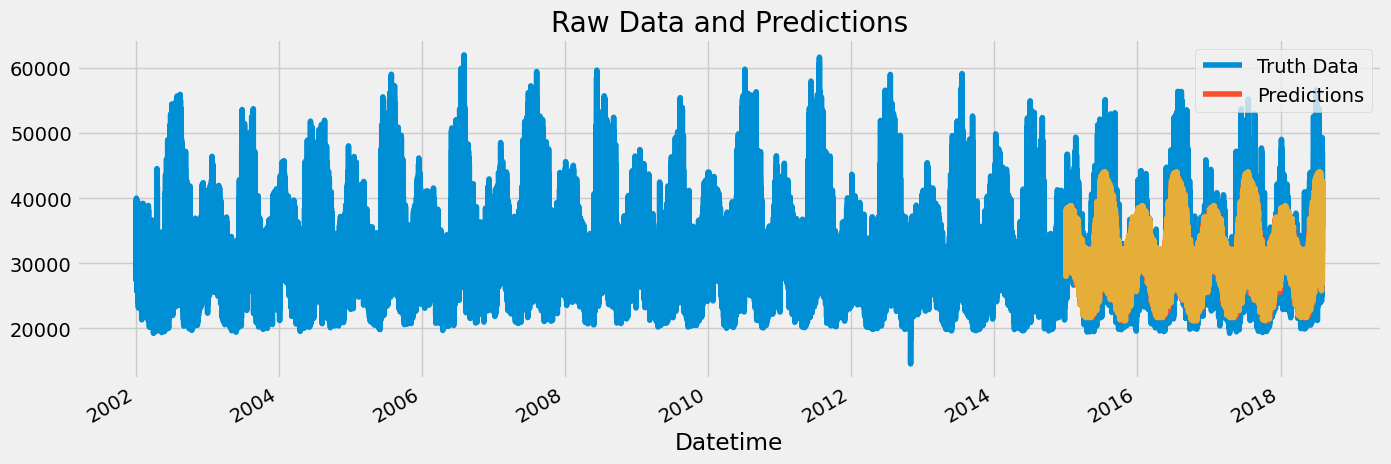

In [54]:
test["prediction"] = reg.predict(X_test)

# Columns that might conflict after multiple runs
cols_to_drop = ['prediction', 'prediction_x', 'prediction_y']
for col in cols_to_drop:
    if col in PJME_data.columns:
        PJME_data = PJME_data.drop(columns=[col])

# Now perform the merge
PJME_data = PJME_data.merge(test[["prediction"]], how='left', left_index=True, right_index=True)

# Rest of your plotting code
ax = PJME_data[["PJME_MW", "prediction"]].plot(figsize=(15, 5))
# Ensure the 'prediction' column exists and is what you expect before plotting
if "prediction" in PJME_data:
    PJME_data["prediction"].plot(ax=ax, style="-.")
else:
    print("Warning: 'prediction' column not found in PJME_data after merge.")
ax.set_title("Raw Data and Predictions")
ax.legend(["Truth Data", "Predictions"]) # Adjust legend based on what's plotted
plt.show()

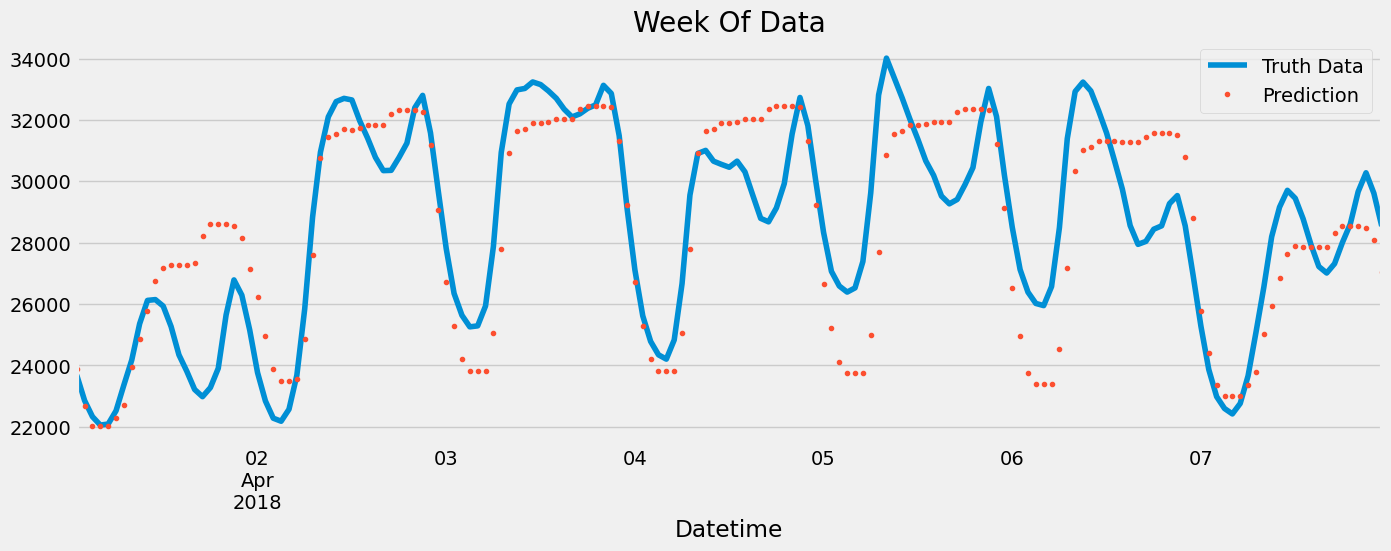

In [45]:
ax = PJME_data.loc[(PJME_data.index > '04-01-2018') & (PJME_data.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
PJME_data.loc[(PJME_data.index > '04-01-2018') & (PJME_data.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()